In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from geomloss import SamplesLoss
from torchvision.models import resnet50, resnet18,resnet101
import random
import math
from torch.autograd import Variable

# Load the CIFAR10 dataset
transform = transforms.Compose(
    [
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#Get an initial set of 100 data points
initial_indices = torch.randperm(len(trainset))[:100]
initial_dataset = torch.utils.data.Subset(trainset, initial_indices)
initial_dataloader = DataLoader(dataset=initial_dataset, batch_size=10, shuffle=True)

# Randomly select 1000 unlabelled datapoints
unlabelled_indices = torch.randperm(len(trainset))[:1000]
unlabeled_dataset = torch.utils.data.Subset(trainset, unlabelled_indices)

# Filter the dataset to include only two classes, say, classes 0 and 1
labelled_indices = [i for i, (img, label) in enumerate(trainset) if label in [0, 1]]

# From the filtered dataset, randomly select 100 datapoints
labelled_indices = torch.randperm(len(labelled_indices))[:100]
query_dataset = torch.utils.data.Subset(trainset, labelled_indices)


In [ ]:
class customSampler(torch.utils.data.Sampler):
    def __init__(self, ind):
        self.ind = ind
        return
    def __iter__(self):
        return iter(self.ind)



In [ ]:



def feature_extraction(inp, layer_name,model):
        feature = {}
        
        def get_features(name):
            def hook(model, inp, output):
                feature[name] = output.detach()
            return hook
        for name, layer in model._modules.items():
            if name == layer_name:
                layer.register_forward_hook(get_features(layer_name))
        output = model(inp)
        return torch.squeeze(feature[layer_name])

def get_feature_embedding(dataset, unlabeled, layer_name, model):
        dataloader = DataLoader(dataset, batch_size = 1000, shuffle = False)
        features = []
        if(unlabeled):
            for batch_idx, inputs in enumerate(dataloader):
                inputs = inputs.to(device)
                batch_features = feature_extraction(inputs, layer_name,model)
                features.append(batch_features)
        else:
            for batch_idx, (inputs,_) in enumerate(dataloader):
                inputs = inputs.to(device)
                batch_features = feature_extraction(inputs, layer_name,model)
                features.append(batch_features)
        return torch.vstack(features)

class customSampler(torch.utils.data.Sampler):
    def __init__(self, ind):
        self.ind = ind
        return
    def __iter__(self):
        return iter(self.ind)

def _proj_simplex(v):
    """
    v: PyTorch Tensor to be projected to a simplex

    Returns:
    w: PyTorch Tensor simplex projection of v
    """
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w

In [ ]:
device = "cuda:"+str(0) if torch.cuda.is_available() else "cpu"
net = resnet50(pretrained=True)
net=net.to(device)

# Step : Fine-tune the ResNet on the initial data until overfitting

# Freeze all layers of the model
for param in net.parameters():
    param.requires_grad = False

# Unfreeze the last layer (assuming it is a fully connected layer)
for param in net.fc.parameters():
    param.requires_grad = True

optimizer_ft = torch.optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 25  # or increase until you observe overfitting
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(initial_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_ft.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

loss_func = SamplesLoss("sinkhorn", p=2, blur=0.05, scaling=0.8)

unlabeled_dataset_len=len(unlabeled_dataset)
shuffled_indices = list(range(unlabeled_dataset_len))
random.shuffle(shuffled_indices)
sampler = customSampler(shuffled_indices)

query_dataset_len = len(query_dataset)
minibatch_size = 100
step_size=10
num_batches = math.ceil(unlabeled_dataset_len/minibatch_size)


 #uniform distribution of weights
simplex_target= Variable(torch.ones(unlabeled_dataset_len, requires_grad=True, device=device)/unlabeled_dataset_len)
beta = torch.ones(query_dataset_len, requires_grad=False)/query_dataset_len
unlabeled_dataloader = DataLoader(dataset=unlabeled_dataset, batch_size=minibatch_size, shuffle=False, sampler=sampler)
target_dataloader = DataLoader(dataset=query_dataset, batch_size=len(query_dataset), shuffle=False)

target_iter=iter(target_dataloader)

target_imgs, _= next(target_iter)
target_imgs=target_imgs.to(device)
beta = beta.to(device)

# Hyperparameters
lr = 0.1
step_size = 20
optimizer = torch.optim.Adam([simplex_target], lr=lr)
    
# Define the learning rate scheduler
scheduler_target = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
simplex_target.requires_grad = True
        


# Create lists to store the loss values
        
overall_loss=[]
        
# Loop over the datasets 10 times
for i in range(100):
    
    simplex_target.grad = None  # Reset gradients at the beginning of each epoch
    batch_idx = 0
    # Initialize loss_avg as a tensor with requires_grad=True
    loss_avg = torch.tensor(0.0, requires_grad=True)
    print("Epoch:", i)
    optimizer.zero_grad()
    #batchwise WD calculation
    for unlabeled_imgs,_ in unlabeled_dataloader:
                
        unlabeled_data_features = get_feature_embedding(unlabeled_imgs, True, 'avgpool',net)
        target_features = get_feature_embedding(target_imgs, True, 'avgpool',net)
                    
                    
        simplex_batch_target = simplex_target[batch_idx * unlabeled_dataloader.batch_size : (batch_idx + 1) * unlabeled_dataloader.batch_size]
        #TODO: should we average or project?
        simplex_batch_target = simplex_batch_target.clone() / simplex_batch_target.sum()

        weights_batch = simplex_target[batch_idx*minibatch_size:(batch_idx+1)*minibatch_size]
        simplex_batch_target=simplex_batch_target.to(device)
        unlabeled_imgs=unlabeled_imgs.to(device)
        loss = loss_func(simplex_batch_target, unlabeled_imgs.view(len(unlabeled_imgs), -1), beta, target_imgs.view(len(target_imgs), -1))
        overall_loss.append(loss.item())
                
        loss_avg = loss_avg + loss / num_batches
                
        batch_idx += 1
        print("Batchwise loss: {}".format(loss))
            
    loss_avg.backward()
    optimizer.step()
    scheduler_target.step()
            
    with torch.no_grad():
        simplex_target.data = _proj_simplex(simplex_target.data)
   
    print("Avg loss: {}".format(loss_avg))

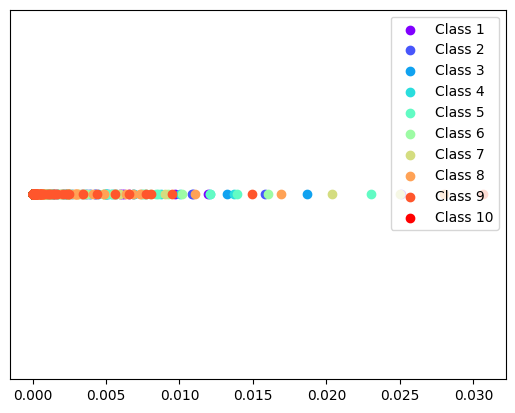

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your unlabeled_dataset is a PyTorch Dataset that returns a tuple of (image, class) 
# and that 'classes' is a list of class labels for each image in the dataset

classes = np.array([label for _, label in unlabeled_dataset])

# Converting the simplex_target tensor to numpy array for plotting
simplex_np = simplex_target.detach().cpu().numpy()

# Setting up the y-values to be 1 since it's a one-dimensional plot
y = np.ones_like(simplex_np)

# create a color map to color your data points based on their class
colors = plt.cm.rainbow(np.linspace(0, 1, 10))  # 10 distinct colors for 10 classes

fig, ax = plt.subplots()

for i in range(1, 11):  # assuming classes range from 1 to 10
    ax.scatter(simplex_np[classes==i], y[classes==i], color=colors[i-1], label='Class '+str(i))

ax.set_yticks([])  # remove the y-axis
ax.legend(loc='upper right')

plt.show()
